In [2]:
import pandas as pd
import numpy as np
import matplotlib.backends.backend_tkagg
import matplotlib.pylab as plt
from astropy.io import fits
from astropy import units as units
import astropy.io.fits as pyfits
from astropy.convolution import Gaussian1DKernel, convolve
from extinction import calzetti00, apply, ccm89
from scipy import optimize
import sys
import time
import emcee
import corner
from multiprocessing import Pool,cpu_count
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
emcee.__version__

8 CPUs


'3.0.2'

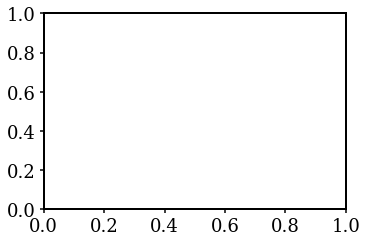

In [4]:
plt.tight_layout()
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=12, family='serif')
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=4)
plt.rc('ytick.major', width=1.5, size=4)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.subplots_adjust(bottom=0.2, left=0.2)

In [238]:
# ### Reading Spectra
df_cat=pd.read_csv('/Volumes/My Passport/goodsn_3dhst_v4.1.5_catalogs/goodsn_3dhst.v4.1.5.zbest.rf',delim_whitespace=True,header=None,comment='#',index_col=False)
df_cat.columns=["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153","L154","nfilt154", "L155", "nfilt155", "L161", "nfilt161", "L162", "nfilt162","L163", \
                "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158","L159", "nfilt159", "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136",\
                "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271", "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]

# df = pd.read_csv('/Volumes/My Passport/GV_CMD_fn_table_20180904/matching_galaxies_goodsn_20180823_GV.csv', sep=',')
# df = pd.read_csv('/Volumes/My Passport/TPAGB/database/matching_galaxies_goodsn_20200206_PSB.csv', sep=',')
df = pd.read_csv('/Volumes/My Passport/TPAGB/database/matching_galaxies_goodsn_20200301_PSB.csv', sep=',')
df = pd.read_csv('/Volumes/My Passport/TPAGB/database/matching_galaxies_goodsn_20200303_PSB.csv', sep=',')

df.columns=['detector','ID','region','filename','chip']

df_photometry=pd.read_csv('/Volumes/My Passport/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat', delim_whitespace=True,header=None,comment='#',index_col=False)
df_photometry.columns=["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W", "f_F160W", "e_F160W", "w_F160W",\
            "f_U", "e_U", "w_U","f_F435W", "e_F435W", "w_F435W", "f_B", "e_B", "w_B", "f_G", "e_G", "w_G","f_V", "e_V", "w_V","f_F606W", "e_F606W","w_F606W",\
            "f_R", "e_R", "w_R", "f_Rs", "e_Rs", "w_Rs","f_I", "e_I", "w_I",\
            "f_F775W", "e_F775W", "w_F775W","f_Z", "e_Z", "w_Z", "f_F850LP", "e_F850LP", "w_F850LP",\
            "f_F125W", "e_F125W", "w_F125W", "f_J", "e_J", "w_J", "f_F140W", "e_F140W", "w_F140W",\
            "f_H", "e_H", "w_H","f_Ks", "e_Ks", "w_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2", "w_IRAC2",\
            "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", \
            "tot_cor", "wmin_ground", \
            "wmin_hst","wmin_wfc3", "wmin_irac", "z_spec", "star_flag",  "kron_radius", \
            "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", \
            "flags", "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag",\
            "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]

df_fast = pd.read_csv('/Volumes/My Passport/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout', delim_whitespace=True,header=None,comment='#',index_col=False)
df_fast.columns = ['id', 'z', 'ltau', 'metal','lage','Av','lmass','lsfr','lssfr','la2t','chi2']
df_zfit = pd.read_csv('/Volumes/My Passport/goodsn_3dhst_v4.1.5_catalogs/goodsn_3dhst.v4.1.5.zfit.concat.dat',delim_whitespace=True,header=None,comment='#',index_col=False)
df_zfit.columns=['phot_id','grism_id','jh_mag','z_spec','z_peak_phot','z_phot_l95',\
                'z_phot_l68','z_phot_u68','z_phot_u95','z_max_grism','z_peak_grism',\
                'l95','l68','u68','u95','f_cover','f_flagged','max_contam','int_contam',\
                'f_negative','flag1','flag2']

In [7]:
# ###  Ma05
norm_wavelength= 5500.0
df_Ma = pd.read_csv('/Volumes/My Passport/M09_ssp_pickles.sed',delim_whitespace=True,header=None, comment='#',index_col=False)# only solar metallicity is contained in this catalogue
df_Ma.columns = ['Age','ZH','l','Flambda']
age = df_Ma.Age
metallicity = df_Ma.ZH
wavelength = df_Ma.l
Flux = df_Ma.Flambda
age_1Gyr_index = np.where(age==1.0)[0]
age_1Gyr = age[age_1Gyr_index]
metallicity_1Gyr = metallicity[age_1Gyr_index]
wavelength_1Gyr = wavelength[age_1Gyr_index]
Flux_1Gyr = Flux[age_1Gyr_index]
F_5500_1Gyr_index=np.where(wavelength_1Gyr==norm_wavelength)[0]
F_5500_1Gyr = Flux_1Gyr[wavelength_1Gyr==norm_wavelength].values # this is the band to be normalized 

# ### Ma13
df_M13 = pd.read_csv('/Volumes/My Passport/M13_models/sed_M13.ssz002',delim_whitespace=True,header=None,comment='#',index_col=False)
df_M13.columns = ['Age','ZH','l','Flambda']
age_M13 = df_M13.Age
metallicity_M13 = df_M13.ZH
wavelength_M13 = df_M13.l
Flux_M13 = df_M13.Flambda
age_1Gyr_index_M13 = np.where(age_M13==1.0)[0]#[0]
age_1Gyr_M13 = age_M13[age_1Gyr_index_M13]
metallicity_1Gyr_M13 = metallicity_M13[age_1Gyr_index_M13]
wavelength_1Gyr_M13 = wavelength_M13[age_1Gyr_index_M13]
Flux_1Gyr_M13 = Flux_M13[age_1Gyr_index_M13]
F_5500_1Gyr_index_M13=np.where(abs(wavelength_1Gyr_M13-norm_wavelength)<15)[0]
F_5500_1Gyr_M13 = 0.5*(Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[0]]+Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[1]])


# ### BC03
df_BC = pd.read_csv('/Volumes/My Passport/ssp_900Myr_z02.spec',delim_whitespace=True,header=None,comment='#',index_col=False)
df_BC.columns=['Lambda','Flux']
wavelength_BC = df_BC.Lambda
Flux_BC = df_BC.Flux
F_6000_BC_index=np.where(wavelength_BC==norm_wavelength)[0]
Flux_BC_norm = Flux_BC[F_6000_BC_index]

### Read in the BC03 models High-resolution, with Stelib library, Salpeter IMF, solar metallicity
BC03_fn='/Volumes/My Passport/bc03/models/Stelib_Atlas/Salpeter_IMF/bc2003_hr_stelib_m62_salp_ssp.ised_ASCII'
BC03_file = open(BC03_fn,"r")
BC03_X = []
for line in BC03_file:
    BC03_X.append(line)
BC03_SSP_m62 = np.array(BC03_X)
BC03_age_list = np.array(BC03_SSP_m62[0].split()[1:])
BC03_age_list_num = BC03_age_list.astype(np.float)/1.0e9 # unit is Gyr
BC03_wave_list = np.array(BC03_SSP_m62[6].split()[1:])
BC03_wave_list_num = BC03_wave_list.astype(np.float)
BC03_flux_list = np.array(BC03_SSP_m62[7:-12])
BC03_flux_array = np.zeros((221,7178))
for i in range(221):
    BC03_flux_array[i,:] = BC03_flux_list[i].split()[1:]
    BC03_flux_array[i,:] = BC03_flux_array[i,:]/BC03_flux_array[i,2556]# Normalize the flux


In [314]:
def find_nearest(array,value):
    idx = np.argmin(np.abs(array-value))
    return idx
def read_spectra(row):
    """
    region: default 1 means the first region mentioned in the area, otherwise, the second region/third region
    """
    detector=df.detector[row]
    region = df.region[row]
    chip = df.chip[row]
    ID = df.ID[row]
    redshift_1=df_cat.loc[ID-1].z_best
    mag = -2.5*np.log10(df_cat.loc[ID-1].L161)+25
    #print mag
    #WFC3 is using the infrared low-resolution grism, and here we are using the z band
    if detector == 'WFC3':
        filename="/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-"+"{0:02d}".format(region)+"/1D/ASCII/goodsn-"+"{0:02d}".format(region)+"-G141_"+"{0:05d}".format(ID)+".1D.ascii"
        OneD_1 = np.loadtxt(filename,skiprows=1)
    if detector =="ACS":
        filename="/Volumes/My Passport/GOODSN_ACS_V4.1.5/acs-goodsn-"+"{0:02d}".format(region)+"/1D/FITS/"+df.filename[row]
        OneD_1 = fits.getdata(filename, ext=1)
    return ID, OneD_1,redshift_1, mag
def reduced_chi_square(data_wave,data,data_err,model_wave,model):
    n=len(data_wave)
    chi_square = 0
    for i in range(n):
        index = find_nearest(model_wave,data_wave[i]);#print index
        #print (data[i]-model[index])**2/(data_err[i]**2)
        chi_square += (data[i]-model[index])**2/(data_err[i]**2)
        #print chi_square
    reduced_chi_square = chi_square/n
    return reduced_chi_square
def Lick_index_ratio(wave, flux, band=3):
    if band == 3:
        blue_min = 1.06e4  # 1.072e4#
        blue_max = 1.08e4  # 1.08e4#
        red_min = 1.12e4  # 1.097e4#
        red_max = 1.14e4  # 1.106e4#
        band_min = blue_max
        band_max = red_min


    # Blue
    blue_mask = (wave >= blue_min) & (wave <= blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]

    # Red
    red_mask = (wave >= red_min) & (wave <= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]

    band_mask = (wave >= band_min) & (wave <= band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]

    if len(blue_wave) == len(red_wave) and len(blue_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif red_wave == []:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif len(blue_wave) != 0 and len(red_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)

    # ratio_err = np.sqrt(np.sum(1/red_flux**2*blue_flux_err**2)+np.sum((blue_flux/red_flux**2*red_flux_err)**2))

    return ratio  # , ratio_err
    if band == 2:
        blue_min = 0.89e4#0.876e4
        blue_max = 0.90e4#0.88e4
        red_min = 0.918e4#0.957e4
        red_max = 0.926e4#0.965e4
        band_min = 0.91e4
        band_max = 0.95e4
    if band == 3:
        blue_min = 1.06e4#1.072e4#
        blue_max = 1.08e4#1.08e4#
        red_min = 1.12e4#1.097e4#
        red_max = 1.14e4#1.106e4#
        band_min = blue_max
        band_max = red_min
    # Blue 
    blue_mask = (wave>= blue_min) & (wave<=blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]
    # Red
    red_mask = (wave>= red_min) & (wave<= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]
    
    band_mask = (wave>=band_min) & (wave<=band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]
    
    if len(blue_wave)==len(red_wave) and len(blue_wave)!= 0:
        ratio = np.mean(blue_flux)/np.mean(red_flux)
    elif red_wave == []:
        ratio = 0
    elif len(blue_wave)!=0 and len(red_wave) >=2:
        ratio = np.mean(blue_flux)/np.mean(red_flux)
    else:
        ratio = 0    
    print('Ratio', ratio)
    return ratio
def binning_spec_keep_shape(wave,flux,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned#, flux_err_binned
def derive_1D_spectra_Av_corrected(OneD_1, redshift_1, rownumber, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod, A_v):
    """
    OneD_1 is the oneD spectra
    redshift_1 is the redshift of the spectra
    rownumber is the row number in order to store the spectra
    """
    region = df.region[rownumber]
    ID = df.ID[rownumber]
    n = len(OneD_1)
    age = 10**(df_fast.loc[ID-1].lage)/1e9 ## in Gyr
    metal = df_fast.loc[ID-1].metal
    sfr = 10**(df_fast.loc[ID-1].lsfr)
    intrinsic_Av = df_fast.loc[ID-1].Av
    
    norm_factor_BC = int((OneD_1[int(n/2+1)][0]-OneD_1[int(n/2)][0])/(1+redshift_1)/1)
    norm_limit_BC = int(5930/norm_factor_BC)*norm_factor_BC+400
    smooth_wavelength_BC_1 = wavelength_BC[400:norm_limit_BC].values.reshape(-1,norm_factor_BC).mean(axis=1)
    smooth_wavelength_BC = np.hstack([smooth_wavelength_BC_1,wavelength_BC[norm_limit_BC:]])

    smooth_Flux_BC_1 = Flux_BC[400:norm_limit_BC].values.reshape(-1,norm_factor_BC).mean(axis=1)
    smooth_Flux_BC = np.hstack([smooth_Flux_BC_1,Flux_BC[norm_limit_BC:]])/Flux_BC_norm.values[0]
    
    norm_factor_Ma = int((OneD_1[int(n/2+1)][0]-OneD_1[int(n/2)][0])/(1+redshift_1)/5)
    norm_limit_Ma = int(4770/norm_factor_Ma)*norm_factor_Ma
    smooth_wavelength_Ma = wavelength_1Gyr[:norm_limit_Ma].values.reshape(-1,norm_factor_Ma).mean(axis=1)
    smooth_Flux_Ma_1Gyr = Flux_1Gyr[:norm_limit_Ma].values.reshape(-1,norm_factor_Ma).mean(axis=1)/F_5500_1Gyr
     

    if redshift_1<=0.14:
        i = 9
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at F606W: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.22:
        i = 3
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at R: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.30:
        i = 7
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at Keck Rs: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.40:
        i = 10
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at F775W: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    elif redshift_1<=0.50:
        i = 4
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at i: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    else:
        i = 5
        temp_norm_wave = wave_list[i]/(1+redshift_1)
        index_wave_norm = find_nearest(smooth_wavelength_BC,temp_norm_wave)
        norm_band = photometric_flux[i] 
        #plt.text(5000,0.55,'normalized at z: rest frame '+"{0:.2f}".format(temp_norm_wave),fontsize=16)
        #plt.axvline(temp_norm_wave,linewidth=2,color='b')
    
    x = np.zeros(n)
    y = np.zeros(n)
    y_err = np.zeros(n)
    sensitivity = np.zeros(n)
    for i in range(0,n):
        x[i] = OneD_1[i][0]#/(1+redshift_1)
    print('wavelength range:',x[0],x[-1])
    spectra_extinction = calzetti00(x, A_v, 4.05)

    for i in range(n):
        spectra_flux_correction = 10**(0.4*spectra_extinction[i])# from obs to obtain the true value: the absolute value
        x[i] = x[i]/(1+redshift_1)
        y[i] = (OneD_1[i][1]-OneD_1[i][3])/OneD_1[i][6]*spectra_flux_correction#/Flux_0 # (flux-contamination)/sensitivity
        y_err[i] = OneD_1[i][2]/OneD_1[i][6]*spectra_flux_correction#/Flux_0
        sensitivity[i] = OneD_1[i][6]
#     print(np.diff(sensitivity[263:282],1)[1:])
    end_index = np.argmin(np.diff(sensitivity[263:282],2)[1:],0)+263
    start_index = np.argmin(np.diff(sensitivity[40:50],2)[1:])+42

    print('masking region:',x[start_index]*(1+redshift_1),x[end_index]*(1+redshift_1),start_index,end_index)
    # plt.plot(x*(1+redshift_1),sensitivity,color='k')
    # plt.plot(x[start_index:end_index]*(1+redshift_1),sensitivity[start_index:end_index],color='red')
    print('before masking',len(x))
    x = x[start_index:end_index]#[int(n*2/10):int(n*8/10)]
    y = y[start_index:end_index]*1e-17/norm_band#[int(n*2/10):int(n*8/10)]*1e-17/norm_band
    y_err = y_err[start_index:end_index]*1e-17/norm_band#[int(n*2/10):int(n*8/10)]*1e-17/norm_band
    print('after masking',len(x))

    mask_non_neg_photo = np.where(photometric_flux>0)
    wave_list = wave_list[mask_non_neg_photo]
    band_list = band_list[mask_non_neg_photo]
    photometric_flux = photometric_flux[mask_non_neg_photo]
    photometric_flux_err = photometric_flux_err[mask_non_neg_photo]
    photometric_flux_err_mod = photometric_flux_err_mod[mask_non_neg_photo]
    return x, y, y_err, wave_list/(1+redshift_1), band_list/(1+redshift_1), photometric_flux/norm_band, photometric_flux_err/norm_band, photometric_flux_err_mod/norm_band 
def model_identification(chi2_array,rtol=0.1):
    index = find_nearest(chi2_array,1)    
    model = np.mod(index,3)+1
    chi2_array_comp = abs(chi2_array-1)
    chi2_array_comp_idx = np.argsort(chi2_array_comp)[:2]
    if np.mod(chi2_array_comp_idx[0],3)==np.mod(chi2_array_comp_idx[1],3):
        chi2_array_comp_idx = np.argsort(chi2_array_comp)[1:3]
    chi2_min2_array = chi2_array[chi2_array_comp_idx]
    if np.isclose(chi2_min2_array[0],chi2_min2_array[1],rtol=rtol):
        model = 0
    return model
def model_from_chi2(df_opt):
    for i in range(len(df_opt)):
        chi2_array=df_opt.loc[i,['x2_M05_opt','x2_M13_opt','x2_BC_opt',\
                                 'x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50']].values
        chi2_spec_array=df_opt.loc[i,['x2_spectra_M05_opt','x2_spectra_M13_opt','x2_spectra_BC_opt',\
                                      'x2_spectra_M05_MCMC50','x2_spectra_M13_MCMC50','x2_spectra_BC_MCMC50']].values
        chi2_phot_array=df_opt.loc[i,['x2_photo_M05_opt','x2_photo_M13_opt','x2_photo_BC_opt',\
                                      'x2_photo_M05_MCMC50','x2_photo_M13_MCMC50','x2_photo_BC_MCMC50']].values
        age_array=df_opt.loc[i,['M05_age_opt','M13_age_opt','BC_age_opt',\
                                'M05_age_MCMC50','M13_age_MCMC50','BC_age_MCMC50']].values
        age_std_array=df_opt.loc[i,['M05_age_std','M13_age_std','BC_age_std',\
                                    'M05_age_std','M13_age_std','BC_age_std']].values
        AV_array=df_opt.loc[i,['M05_AV_opt','M13_AV_opt','BC_AV_opt',\
                               'M05_AV_MCMC50','M13_AV_MCMC50','BC_AV_MCMC50']].values
        AV_std_array=df_opt.loc[i,['M05_AV_std','M13_AV_std','BC_AV_std',\
                                   'M05_AV_std','M13_AV_std','BC_AV_std']].values        
        index = find_nearest(chi2_array,0)    
        df_opt.loc[i,'model'] = np.mod(index,3)+1
        df_opt.loc[i,'model_new']=model_identification(chi2_array)
        df_opt.loc[i,'best_chi2']=chi2_array[index]
        df_opt.loc[i,'best_chi2_spec']=chi2_spec_array[index]
        df_opt.loc[i,'best_chi2_phot']=chi2_phot_array[index]
        df_opt.loc[i,'age_opt']=age_array[index]
        df_opt.loc[i,'age_opt_std']=age_std_array[index]
        df_opt.loc[i,'AV_opt']=AV_array[index]
        df_opt.loc[i,'AV_opt_std']=AV_std_array[index]
    return df_opt

def binning_spec_keep_shape_x(wave,flux,flux_err,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    flux_err_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))+1):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
        flux_err_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux_err[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned, flux_err_binned
def minimize_age_AV_vector_weighted(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]

    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    if 0.01<galaxy_age<13.0 and 0.0<intrinsic_Av<4.0 and not np.isinf(x2+1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf
def minimize_age_AV_vector_weighted_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    #print('galaxy age', galaxy_age, 'age prior:', age_prior)
    AV_string = str(intrinsic_Av)
    #print('intrinsic Av:', intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age <= 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo, model1[0,:], smooth_Flux_Ma_1Gyr_new
def minimize_age_AV_vector_weighted_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    #print('galaxy age', galaxy_age, 'age prior:', age_prior)
    AV_string = str(intrinsic_Av)
    #print('intrinsic Av:', intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
            #print(fn1, fn2)
            model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new
    
    binning_index = find_nearest(model1[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model1[0,binning_index]-model1[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model1[0,binning_index]-model1[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    else:
        binning_size = int((model1[0,binning_index]-model1[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model1[0,:], smooth_Flux_Ma_1Gyr_new) 
        # print('binning data, model 1', n, (model1[0,binning_index]-model1[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    return x2,x2_photo

def minimize_age_AV_vector_weighted_M13(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)     
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_M13(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new
    
    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf
def minimize_age_AV_vector_weighted_M13_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo, model2[0,:], smooth_Flux_M13_1Gyr_new
def minimize_age_AV_vector_weighted_M13_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior < 1 and age_prior>=1e-4:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
            fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
            model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
        else:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
            model2 = np.genfromtxt(fn1)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    binning_index = find_nearest(model2[0,:],np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) > (model2[0,binning_index]-model2[0,binning_index-1]):
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(model2[0,binning_index]-model2[0,binning_index-1]))
        model_wave_binned,model_flux_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('binning model, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    
    else:
        binning_size = int((model2[0,binning_index]-model2[0,binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned = binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, model2[0,:], smooth_Flux_M13_1Gyr_new) 
        # print('binning data, model 2', n, (model2[0,binning_index]-model2[0,binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]),binning_size)    

    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    return x2, x2_photo

def minimize_age_AV_vector_weighted_BC03(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)
    # print(galaxy_age,age_prior)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    # print('BC x2_nu',x2,x2_photo,0.5*weight1*x2+0.5*weight2*x2_photo)
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_BC03(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   
    else:
        model3_flux = BC03_flux_array[-1, :7125]   
    
    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf
def minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                            + BC03_flux_array[age_index, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                            + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)     
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo,BC03_flux_attenuated
def minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return x2,x2_photo
def minimize_age_AV_vector_weighted_BC03_mod(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                    + BC03_flux_array[age_index, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                    + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    return 0.5*weight1*x2+0.5*weight2*x2_photo
def lg_minimize_age_AV_vector_weighted_return_BC03_mod(X):
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                    + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                    + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   
    else:
        model3_flux = BC03_flux_array[-1, :7125]   
    
    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    binning_index = find_nearest(BC03_wave_list_num, np.median(x))
    if (x[int(n/2)]-x[int(n/2)-1]) < (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]):
        binning_size = int((BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1])/(x[int(n/2)]-x[int(n/2)-1]))
        x_binned,y_binned,y_err_binned=binning_spec_keep_shape_x(x,y,y_err,binning_size)
        x2 = reduced_chi_square(x_binned, y_binned, y_err_binned, BC03_wave_list_num, BC03_flux_attenuated) 
        # print('bin data', binning_size, x2)
    else: 
        binning_size = int((x[int(n/2)]-x[int(n/2)-1])/(BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]))
        model_wave_binned, model_flux_binned = binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated,binning_size)
        x2 = reduced_chi_square(x, y, y_err, model_wave_binned, model_flux_binned) 
        # print('bin model',binning_size, x2)
    # print('binning size, model 3', n, (BC03_wave_list_num[binning_index]-BC03_wave_list_num[binning_index-1]), (x[int(n/2)]-x[int(n/2)-1]), binning_size)    
    x2_photo = reduced_chi_square(wave_list, photometric_flux, photometric_flux_err, BC03_wave_list_num, BC03_flux_attenuated)
    
    if 0.01<galaxy_age<13 and 0.0<intrinsic_Av<4.0 and not np.isinf(0.5*x2+0.5*1e-3*x2_photo):
        return np.log(np.exp(-0.5*(0.5*weight1*x2+0.5*weight2*x2_photo)))
    else:
        return -np.inf

def all_same(items):
    return all(x == items[0] for x in items)

def chisquare_photo(model_wave, model_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod):
    """
    work in the observed frame
    """
    filter_fn_list = []
    path = "/Volumes/My Passport/TAPS/filter/goodsn/"
    model_wave = model_wave*(1+redshift_1)
    model_flux = model_flux
    for i in range(1,19):
        for file in glob.glob("f"+str(i)+"_*"):
            print(i,file)
            fn = path+file
            filter_fn_list.append(fn)
            filter_curve = np.loadtxt(fn)
        
        sum_flambda_AB_K = 0
        sum_transmission = 0
        length = 0

        for j in range(len(filter_curve)-1):
            wave_inter = np.zeros(len(model_wave))
            wave_inter[:-1] = np.diff(model_wave)
            index = np.where(model_wave<filter_curve[j+1,0])[0]#[0]
            wave = model_wave[index]
            flux = model_flux[index]
            wave_inter = wave_inter[index]
            index = np.where(wave>filter_curve[j,0])
            wave = wave[index]
            flux = flux[index]
            wave_inter = wave_inter[index]
            n = len(flux)
            if n!= 0 and n!=1:
                try:
                    transmission = np.interp(wave, filter_curve[j:j+2,0], filter_curve[j:j+2,1])
                except:
                    print('Error')
                # Checking if all spectral elements are the same
                if all_same(wave_inter):
                    flambda_AB_K = np.sum(flux*transmission)
                    sum_flambda_AB_K += flambda_AB_K
                    sum_transmission += np.sum(transmission)
                    length = length+1
                else:
                    flambda_AB_K = np.sum(flux*transmission*wave_inter)
                    sum_flambda_AB_K += flambda_AB_K
                    sum_transmission += np.sum(transmission*wave_inter)
                    length = length+1
            elif n==1:
                transmission = np.interp(wave, filter_curve[j:j+2,0], filter_curve[j:j+2,1])
                flambda_AB_K = flux[0]*transmission[0]
                sum_flambda_AB_K += flambda_AB_K*wave_inter
                sum_transmission += np.sum(transmission)*wave_inter#/len(transmission)#np.trapz(transmission, x=wave)
                length = length+1
        if length == 0:
            photometry_list[i-1]=0
        else:
            photometry_list[i-1] = sum_flambda_AB_K/sum_transmission
    chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2
    print(chisquare_photo_list)
    print(np.sum(chisquare_photo_list))
    return np.sum(chisquare_photo_list)/len(chisquare_photo_list)

In [241]:
columns = ['ID','region','field',
          'M05_age_opt','M05_AV_opt','M13_age_opt','M13_AV_opt','BC_age_opt','BC_AV_opt',\
          'x2_spectra_M05_opt','x2_photo_M05_opt','x2_spectra_M13_opt','x2_photo_M13_opt','x2_spectra_BC_opt','x2_photo_BC_opt',\
          'M05_age_MCMC50','M05_age_std','M05_AV_MCMC50','M05_AV_std','M13_age_MCMC50','M13_age_std','M13_AV_MCMC50','M13_AV_std','BC_age_MCMC50','BC_age_std','BC_AV_MCMC50','BC_AV_std',\
          'x2_spectra_M05_MCMC50','x2_photo_M05_MCMC50','x2_spectra_M13_MCMC50','x2_photo_M13_MCMC50','x2_spectra_BC_MCMC50','x2_photo_BC_MCMC50',\
          'x2_M05_opt','x2_M13_opt','x2_BC_opt','x2_M05_MCMC50','x2_M13_MCMC50','x2_BC_MCMC50',\
          'model','grism_index','grism_index_AV_corr','age_opt','age_opt_std','AV_opt','AV_opt_std']
chi_square_list = pd.DataFrame(index=df.index,columns=columns)
chi_square_list_final = pd.DataFrame(index=df.index,columns=columns)

weight1 = 0.25#0.0#1/1.864#/0.5
weight2 = weight1*5e-3#1.0#1/1228.53#/0.5

nsteps=3000
current_dir = '/Volumes/My Passport/TPAGB/'
outcome_dir = 'outcome/'
date='20200304'
plot_dir = 'plot/'+str(date)+'_goodsn/'

### 0 Read the parameters

In [311]:
row = 3
##
[ID, OneD_1, redshift_1, mag_1] = read_spectra(row)
print(row, ID,redshift_1)        
ID_no = ID-1
redshift = df_photometry.loc[ID_no].z_spec

region = df.region[row]
intrinsic_Av = df_fast.loc[ID-1].Av
print('intrinsic Av:'+str(intrinsic_Av))
galaxy_age = 10**(df_fast.loc[ID-1].lage)/1e9
print('Galaxy age:', galaxy_age)
A_v=0.0304    
c=3e10
chi_square_list.loc[row,'ID'] = float(ID)
chi_square_list.loc[row,'region'] = region
chi_square_list.loc[row,'field'] = 'goodsn'

3 20567 0.6404
intrinsic Av:0.8
Galaxy age: 1.2589254117941662


In [312]:
# Photometry
# G, Rs from Keck Steidel et al (2003)
G_Keck_wave = 4780
G_Keck_band = 888.3/2.
G_Keck = df_photometry.loc[ID_no].f_G/((G_Keck_wave)**2)*c*1e8*3.63e-30
G_Keck_err = df_photometry.loc[ID_no].e_G/((G_Keck_wave)**2)*c*1e8*3.63e-30

Rs_Keck_wave = 6830
Rs_Keck_band = 1239.7/2.
Rs_Keck = df_photometry.loc[ID_no].f_Rs/((Rs_Keck_wave)**2)*c*1e8*3.63e-30
Rs_Keck_err = df_photometry.loc[ID_no].e_Rs/((Rs_Keck_wave)**2)*c*1e8*3.63e-30

## HHDFN from Capak 2004: U B V R I z
# U (KPNO 4m MOSAIC), KPNO_MOSAIC_U
#B V R I z(Subaru 8.3m Suprime-Cam): use the COSMOS filter set
U_wave = 3647.65
U_band = 387.16/2.
U = df_photometry.loc[ID_no].f_U/((U_wave)**2)*c*1e8*3.63e-30
U_err = df_photometry.loc[ID_no].e_U/((U_wave)**2)*c*1e8*3.63e-30

B_wave = 4427.60
B_band = 622.05/2.
B = df_photometry.loc[ID_no].f_B/((B_wave)**2)*c*1e8*3.63e-30
B_err = df_photometry.loc[ID_no].e_B/((B_wave)**2)*c*1e8*3.63e-30

V_wave = 5471.22
V_band = 577.36/2.
V = df_photometry.loc[ID_no].f_V/((V_wave)**2)*c*1e8*3.63e-30
V_err = df_photometry.loc[ID_no].e_V/((V_wave)**2)*c*1e8*3.63e-30

R_wave = 6534.16
R_band = 676.39/2.
R = df_photometry.loc[ID_no].f_R/((R_wave)**2)*c*1e8*3.63e-30
R_err = df_photometry.loc[ID_no].e_R/((R_wave)**2)*c*1e8*3.63e-30

I_wave = 7975.89
I_band = 792.89/2.
I = df_photometry.loc[ID_no].f_I/((I_wave)**2)*c*1e8*3.63e-30
I_err = df_photometry.loc[ID_no].e_I/((I_wave)**2)*c*1e8*3.63e-30

Z_wave = 9069.21
Z_band = 802.63/2.
Z = df_photometry.loc[ID_no].f_Z/((Z_wave)**2)*c*1e8*3.63e-30
Z_err = df_photometry.loc[ID_no].e_Z/((Z_wave)**2)*c*1e8*3.63e-30


## GOODS ACS Giavalisco et al. 2004, http://www.stsci.edu/hst/acs/documents/handbooks/current/c05_imaging2.html
# https://uknowledge.uky.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1264&context=physastron_facpub
# Also on Guo et al. 2013
F435W_wave = 4317
F435W_band = 920/2.
F435W = df_photometry.loc[ID_no].f_F435W/((F435W_wave)**2)*c*1e8*3.63e-30
F435W_err = df_photometry.loc[ID_no].e_F435W/((F435W_wave)**2)*c*1e8*3.63e-30

F606W_wave = 5918
F606W_band = 2324/2.
F606W = df_photometry.loc[ID_no].f_F606W/((F606W_wave)**2)*c*1e8*3.63e-30
F606W_err = df_photometry.loc[ID_no].e_F606W/((F606W_wave)**2)*c*1e8*3.63e-30

F775W_wave = 7693
F775W_band = 1511/2.
F775W = df_photometry.loc[ID_no].f_F775W/((F775W_wave)**2)*c*1e8*3.63e-30
F775W_err = df_photometry.loc[ID_no].e_F775W/((F775W_wave)**2)*c*1e8*3.63e-30

F850LP_wave = 9055
F850LP_band = 1236/2.
F850LP = df_photometry.loc[ID_no].f_F850LP/((F850LP_wave)**2)*c*1e8*3.63e-30
F850LP_err = df_photometry.loc[ID_no].e_F850LP/((F850LP_wave)**2)*c*1e8*3.63e-30

# 3D-HST from Brammers 2013
F140W_wave = 13635
F140W_band = 3947/2.
F140W = df_photometry.loc[ID_no].f_F140W/((F140W_wave)**2)*c*1e8*3.63e-30 #http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=HST/WFC3_IR.F140W
F140W_err = df_photometry.loc[ID_no].e_F140W/((F140W_wave)**2)*c*1e8*3.63e-30

# CANDELS 
F125W_wave = 12486
F125W_band = 3005/2.
F125W = df_photometry.loc[ID_no].f_F125W/((F125W_wave)**2)*c*1e8*3.63e-30
F125W_err = df_photometry.loc[ID_no].e_F125W/((F125W_wave)**2)*c*1e8*3.63e-30

F160W_wave = 15370
F160W_band = 2874/2.
F160W = df_photometry.loc[ID_no].f_F160W/((F160W_wave)**2)*c*1e8*3.63e-30 #http://www.stsci.edu/hst/wfc3/design/documents/handbooks/currentIHB/c07_ir06.html
F160W_err = df_photometry.loc[ID_no].e_F160W/((F160W_wave)**2)*c*1e8*3.63e-30


# J, H, Ks from MODS, Kajisawa (2011)
# SUBARU_MOIRCS J, H, Ks
# http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=Subaru&gname2=MOIRCS
J_wave = 12532.8
J_band = 1537/2.
J = df_photometry.loc[ID_no].f_J/J_wave**2*c*1e8*3.63e-30
J_err = df_photometry.loc[ID_no].e_J/J_wave**2*c*1e8*3.63e-30

H_wave = 16371.2
H_band = 2788/2.
H = df_photometry.loc[ID_no].f_H/H_wave**2*c*1e8*3.63e-30
H_err = df_photometry.loc[ID_no].e_H/H_wave**2*c*1e8*3.63e-30

Ks_wave = 21453.0
Ks_band = 3037.4/2.
Ks = df_photometry.loc[ID_no].f_Ks/Ks_wave**2*c*1e8*3.63e-30
Ks_err = df_photometry.loc[ID_no].e_Ks/Ks_wave**2*c*1e8*3.63e-30

wave_list = np.array([U_wave, B_wave, V_wave, R_wave, I_wave, Z_wave, G_Keck_wave, Rs_Keck_wave,\
                      F435W_wave, F606W_wave, F775W_wave, F850LP_wave, F125W_wave, F140W_wave, F160W_wave,\
                      J_wave, H_wave, Ks_wave])
band_list = np.array([U_band, B_band, V_band, R_band, I_band, Z_band, G_Keck_band, Rs_Keck_band, F435W_band, F606W_band, F775W_band, F850LP_band, F125W_band, F140W_band, F160W_band, J_band, H_band, Ks_band])
photometric_flux = np.array([U, B, V, R, I, Z, G_Keck, Rs_Keck, F435W, F606W, F775W, F850LP, F125W, F140W, F160W, J, H, Ks])
photometric_flux_err = np.array([U_err, B_err, V_err, R_err, I_err, Z_err, G_Keck_err, Rs_Keck_err, F435W_err, F606W_err, F775W_err, F850LP_err, F125W_err, F140W_err, F160W_err,J_err, H_err, Ks_err])
photometric_flux_err_mod = np.array([U_err+0.1*U, B_err+0.1*B, V_err+0.1*V, R_err+0.1*R, I_err+0.1*I, Z_err+0.1*Z, G_Keck_err+0.1*G_Keck, Rs_Keck_err+0.1*Rs_Keck,\
                                F435W_err+0.03*F435W, F606W_err+0.03*F606W, F775W_err+0.03*F775W, F850LP_err+0.03*F850LP, F125W_err+0.03*F125W, F140W_err+0.03*F140W, F160W_err+0.03*F160W,\
                                J_err+0.1*J, H_err+0.1*H, Ks_err+0.1*Ks])
mask_non_neg_photo = np.where(photometric_flux>0)
wave_list = wave_list[mask_non_neg_photo]
band_list = band_list[mask_non_neg_photo]
photometric_flux = photometric_flux[mask_non_neg_photo]
photometric_flux_err = photometric_flux_err[mask_non_neg_photo]
photometric_flux_err_mod = photometric_flux_err_mod[mask_non_neg_photo]


In [313]:
#------------------------------------------------- Reduce the spectra ----------------------------------------------------------
print('-------------------------------------Initial fit ---------------------------------------------------------------------------------------')
[x, y, y_err, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod] = \
derive_1D_spectra_Av_corrected(OneD_1, redshift_1, row, wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod, A_v)

if redshift< 0.49:
    try:
        chi_square_list.loc[row,'grism_index'] = Lick_index_ratio(x,y)
    except:
        pass
# print(y)
# print(photometric_flux)
    # Testing fitting a line
photo_list_for_scaling = []
photo_err_list_for_scaling = []
grism_flux_list_for_scaling = []
grism_flux_err_list_for_scaling = []
grism_wave_list_for_scaling =[]
for i in range(len(wave_list)):
    if (wave_list[i]-band_list[i]) > x[0] and (wave_list[i] + band_list[i]) < x[-1]:
        scale_index = find_nearest(x, wave_list[i])
        photo_list_for_scaling.append(photometric_flux[i])
        photo_err_list_for_scaling.append(photometric_flux_err[i])
        grism_flux_list_for_scaling.append(y[scale_index])
        grism_flux_err_list_for_scaling.append(y_err[scale_index])
        grism_wave_list_for_scaling.append(x[scale_index])
photo_array_for_scaling = np.array(photo_list_for_scaling)
photo_err_array_for_scaling = np.array(photo_err_list_for_scaling)
grism_flux_array_for_scaling = np.array(grism_flux_list_for_scaling)
grism_flux_err_array_for_scaling = np.array(grism_flux_err_list_for_scaling)
grism_wave_array_for_scaling = np.array(grism_wave_list_for_scaling)
print('Number of photometric points for rescaling:',len(photo_array_for_scaling))
# print(grism_flux_array_for_scaling)
# print(photo_array_for_scaling)
print(np.mean(photo_array_for_scaling/grism_flux_array_for_scaling))

coeff = np.mean(photo_array_for_scaling/grism_flux_array_for_scaling)
if coeff < 1:
    coeff = 1
y = y*coeff

-------------------------------------Initial fit ---------------------------------------------------------------------------------------
wavelength range: 10211.26 17564.74
masking region: 11196.45 16516.18 42 267
before masking 312
after masking 225
Number of photometric points for rescaling: 2
1.0350521409728688


In [308]:
chisquare_photo(model_wave, model_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)


1 f1_KPNO_Mosaic.U.dat.txt
2 f2_B_subaru.res.txt
3 f3_V_subaru.res.txt
4 f4_r_subaru.res.txt
5 f5_i_subaru.res.txt
6 f6_z_subaru.res.txt
7 f7_Keck_LRIS.g.dat.txt
8 f8_Keck_LRIS.Rs.dat.txt
9 f9_HST_ACS_HRC.F435W.dat.txt
10 f10_HST_ACS_HRC.F606W.dat.txt
11 f11_HST_ACS_HRC.F775W.dat.txt
12 f12_HST_ACS_HRC.F850LP.dat.txt
13 f13_wfc3-F125W.res.txt
14 f14_wfc3-F140W.res.txt
15 f15_wfc3-F160W.res.txt
16 f16_Subaru_MOIRCS.J.dat.txt
17 f17_Subaru_MOIRCS.H.dat.txt
18 f18_Subaru_MOIRCS.Ks.dat.txt
[ 14.21663925  47.83998458  64.15982413  73.20057208  65.50718145
  48.20039708  49.6285775   70.59825917 172.25231425 724.6385889
 719.30870526 512.61039019  19.55647949   1.37682107  13.14723413
   1.12885022   1.30262375  17.49008747]
2616.163529973078


145.34241833183765

### 1 M05

In [236]:
print('____________________M05_________________________ Optimization__________________________')
X = np.array([galaxy_age, intrinsic_Av])
bnds = ((0.01, 13.0), (0.0, 4.0))
sol = optimize.minimize(minimize_age_AV_vector_weighted, X, bounds = bnds, method='TNC')#, options = {'disp': True})
[age_prior_optimized, AV_prior_optimized] = sol.x
X = sol.x
print(X)
x2_optimized = minimize_age_AV_vector_weighted(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
chi_square_list.loc[row,'M05_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M05_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M05_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M05_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_M05_opt'] = x2_phot


____________________M05_________________________ Optimization__________________________
[0.79432823 0.        ]


Text(0, 0.5, '$\\rm (F_{\\lambda,\\rm data}-F_{\\lambda,\\rm model})/F_{\\lambda,\\rm err}$')

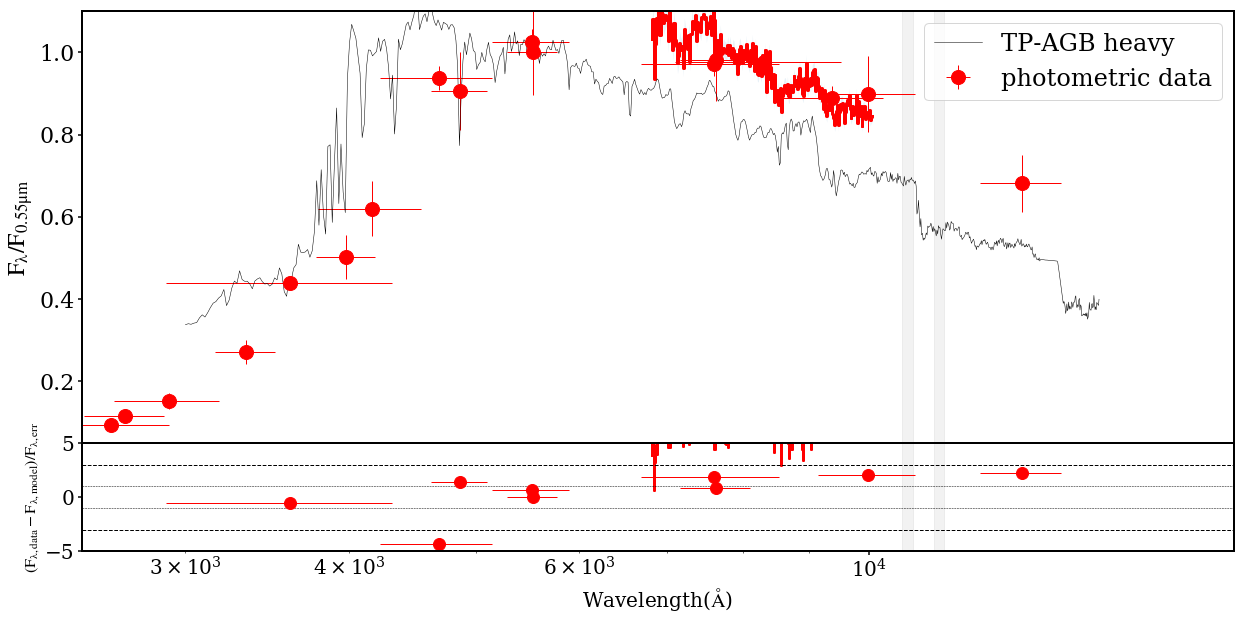

In [317]:
#print(X)
#--- Plot
X = sol.x
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]
model1_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model1_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0, :index0], color='r', linewidth=2)
# print(relative_sigma[0, :index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.ylim([0.9,1.1])
plt.ylim([0.7,1.45])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)

In [17]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized*0.1) & (samples[:,0] < age_prior_optimized*2.0) & (samples[:,1] < AV_prior_optimized*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run M05 MCMC:'+str(tok-tik))    

100%|██████████| 3000/3000 [11:06<00:00,  4.50it/s]


Multiprocessing took 16.3 seconds
Time to run M05 MCMC:16.285471


<Figure size 3200x3200 with 0 Axes>

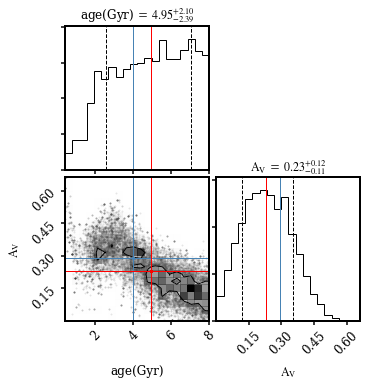

In [19]:
if samples.size > 1e3:
    value2 = np.percentile(samples, 50, axis=0)
    [std_age_prior_optimized, std_AV_prior_optimized] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         truths=[age_prior_optimized, AV_prior_optimized],
         levels=(1-np.exp(-0.5),),
         show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})

[4.95236666 0.2307298 ]


Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

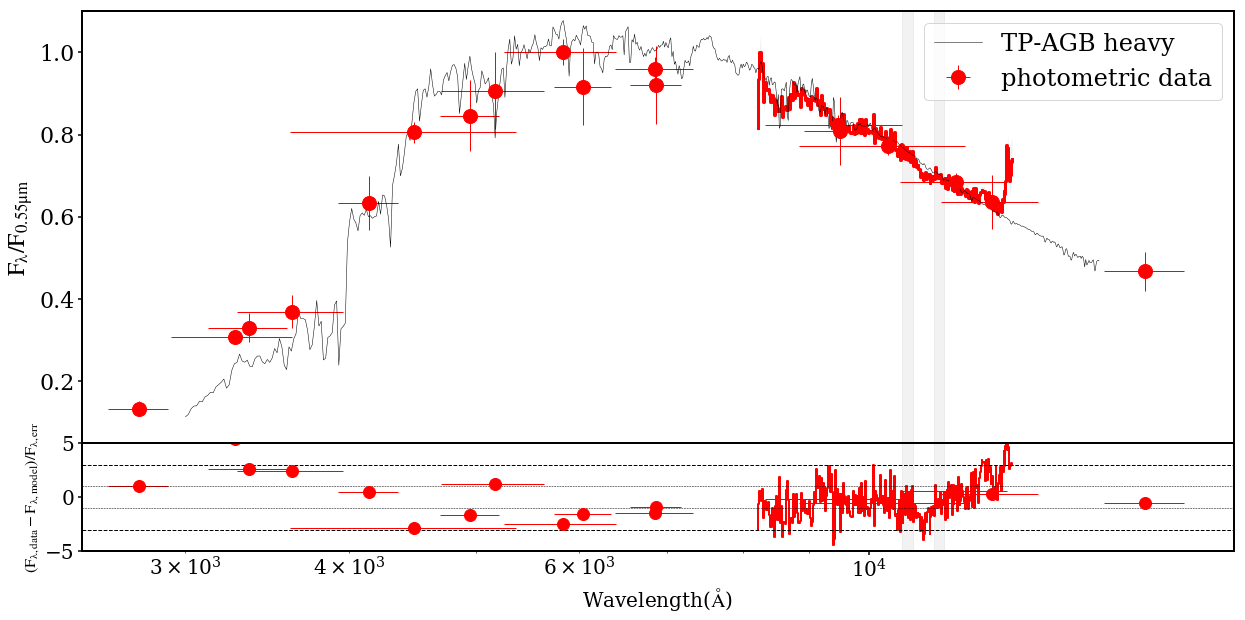

In [20]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
print(X)
x2_optimized = minimize_age_AV_vector_weighted(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_return_chi2_sep(X)
chi_square_list.loc[row,'M05_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M05_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M05_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M05_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_M05_MCMC50'] = x2_phot
chi_square_list.loc[row,'M05_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'M05_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='k',label='TP-AGB heavy',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)

index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)             
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

### 2 M13 model

In [251]:
print('____________________M13_________________________ Optimization__________________________')
bnds = ((0.0, 13.0), (0.0, 4.0))
X = np.array([galaxy_age,intrinsic_Av])
sol_M13 = optimize.minimize(minimize_age_AV_vector_weighted_M13, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized M13 weighted reduced chisqure result:', sol_M13)
[age_prior_optimized_M13, AV_prior_optimized_M13] = sol_M13.x
X = sol_M13.x
x2_optimized = minimize_age_AV_vector_weighted_M13(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
chi_square_list.loc[row,'M13_age_opt'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M13_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M13_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M13_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_M13_opt'] = x2_phot

____________________M13_________________________ Optimization__________________________


Text(0.5, 0, 'Wavelength($\\rm \\AA$)')

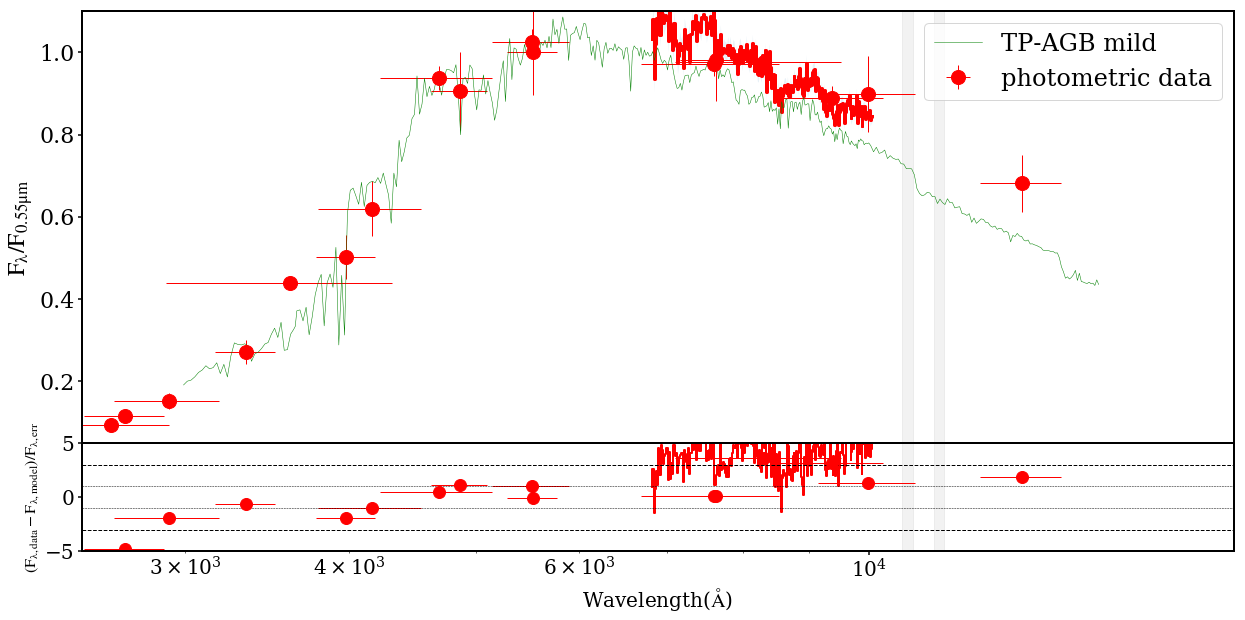

In [315]:
#--- Plot
X = sol_M13.x
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]
model2_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model2_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0, :index0], color='r', linewidth=2)
# print(relative_sigma[0, :index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
# plt.ylim([0.75,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

In [ ]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol_M13.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_M13, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_M13*0.1) & (samples[:,0] < age_prior_optimized_M13*2.0) & (samples[:,1] < AV_prior_optimized_M13*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run M13 MCMC:'+str(tok-tik))

In [ ]:
if samples.size > 1e3 :
    value2=np.percentile(samples, 50, axis=0)
    [std_age_prior_optimized_M13, std_AV_prior_optimized_M13] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
         labels=["age(Gyr)", r"$\rm A_V$"],
         truths=[age_prior_optimized_M13, AV_prior_optimized_M13],
         levels=(1-np.exp(-0.5),),
         show_titles=True,title_kwargs={'fontsize':12},
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
    # Loop over the histograms
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})

In [ ]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted_M13(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_M13_return_chi2_sep(X)
chi_square_list.loc[row,'M13_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'M13_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_M13_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_M13_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_M13_MCMC50'] = x2_phot
chi_square_list.loc[row,'M13_age_std'] = np.std(samples, axis=0)[0]#"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'M13_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
model_wave =minimize_age_AV_vector_weighted_M13_return_flux(X)[1]
model_flux =minimize_age_AV_vector_weighted_M13_return_flux(X)[2]
plt.plot(model_wave, model_flux, color='g',label='TP-AGB mild',lw=0.5)
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0,:index0], color='r', linewidth=2)
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
# plt.ylim([0.75,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)

### 3 BC03 model

In [284]:
print('____________________BC03_________________________ Optimization__________________________')
bnds = ((0.0, 13.0), (0.0, 4.0))
X = np.array([galaxy_age, intrinsic_Av])
sol_BC03 = optimize.minimize(minimize_age_AV_vector_weighted_BC03, X, bounds = bnds, method='TNC')#, options = {'disp': True})
# print('Optimized BC03 weighted reduced chisqure result:', sol_BC03)
[age_prior_optimized_BC03, AV_prior_optimized_BC03] = sol_BC03.x
X = sol_BC03.x
x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
chi_square_list.loc[row,'BC_AV_opt'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_BC_opt'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_BC_opt'] = x2_spec
chi_square_list.loc[row,'x2_photo_BC_opt'] = x2_phot


____________________BC03_________________________ Optimization__________________________


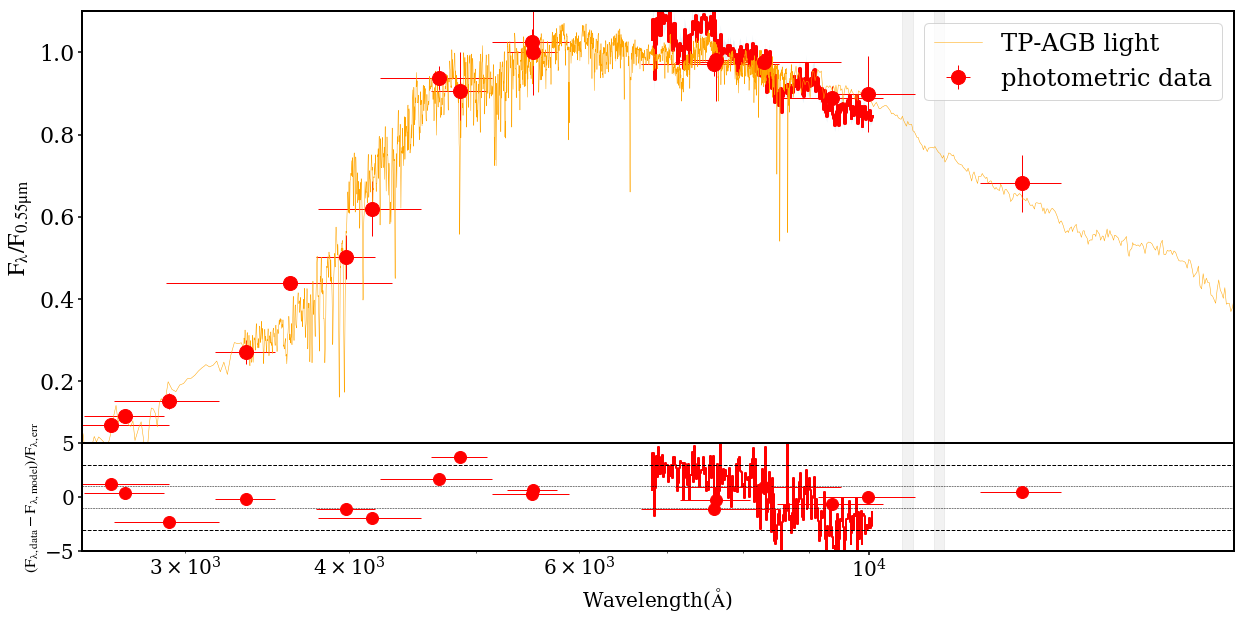

In [285]:
#--- Plot
X = sol_BC03.x
n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
model_wave = BC03_wave_list_num
model_flux = BC03_flux_attenuated   
model3_wave = BC03_wave_list_num
model3_flux = BC03_flux_attenuated   
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0, :index0], color='r', linewidth=2)
# print(relative_sigma[0, :index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
# plt.ylim([0.6,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

In [ ]:
with Pool() as pool:
    ndim, nwalkers = 2, 10
    tik = time.clock()
    p0 = [sol_BC03.x + 4.*np.random.rand(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lg_minimize_age_AV_vector_weighted_BC03, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.chain[:, 500:, :].reshape((-1,ndim))
    samples = samples[(samples[:,0] > age_prior_optimized_BC03*0.1) & (samples[:,0] < age_prior_optimized_BC03*2.0) & (samples[:,1] < AV_prior_optimized_BC03*3.0)]
    tok = time.clock()
    multi_time = tok-tik
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print('Time to run BC03 MCMC:'+str(tok-tik))

In [ ]:
if samples.size > 1e3:
    value2=np.percentile(samples,50,axis=0)
    [std_age_prior_optimized_BC03, std_AV_prior_optimized_BC03] = np.std(samples, axis=0)
    plt.figure(figsize=(32,32),dpi=100)
    fig = corner.corner(samples,
                        labels=["age(Gyr)", r"$\rm A_V$"],\
                        truths=[age_prior_optimized_BC03, AV_prior_optimized_BC03],\
                        show_titles=True,title_kwargs={'fontsize':12},
                        levels=(1-np.exp(-0.5),),
                        quantiles=(0.16,0.5, 0.84))
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(X[i], color="g")
        ax.axvline(value2[i],color='r')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(X[xi], color="g")
            ax.axvline(value2[xi], color="r")
            ax.axhline(X[yi], color="g")
            ax.axhline(value2[yi], color="r")
            ax.plot(X[xi], X[yi], "sg")
            ax.plot(value2[xi],value2[yi],'sr')
    plt.rcParams.update({'font.size': 12})

In [ ]:
#--- Plot
X = np.percentile(samples, 50, axis=0)
x2_optimized = minimize_age_AV_vector_weighted_BC03(X)
x2_spec, x2_phot = minimize_age_AV_vector_weighted_BC03_return_chi2_sep(X)
chi_square_list.loc[row,'BC_age_MCMC50'] = X[0]#"{0:.2f}".format(X[0])
chi_square_list.loc[row,'BC_AV_MCMC50'] = X[1]#"{0:.2f}".format(X[1])
chi_square_list.loc[row,'x2_BC_MCMC50'] = x2_optimized
chi_square_list.loc[row,'x2_spectra_BC_MCMC50'] = x2_spec
chi_square_list.loc[row,'x2_photo_BC_MCMC50'] = x2_phot
chi_square_list.loc[row,'BC_age_std'] = np.std(samples, axis=0)[0] #"{0:.2f}".format(np.std(samples, axis=0)[0])
chi_square_list.loc[row,'BC_AV_std'] = np.std(samples, axis=0)[1]#"{0:.2f}".format(np.std(samples, axis=0)[1])

n = len(x)
fig1 = plt.figure(figsize=(20,10))
frame1 = fig1.add_axes((.1,.35,.8,.6))
plt.step(x, y, color='r',lw=3)
plt.fill_between(x,(y+y_err),(y-y_err),alpha=0.1)
plt.errorbar(wave_list, photometric_flux, xerr=band_list, yerr=photometric_flux_err_mod, color='r', fmt='o', label='photometric data', markersize='14')
BC03_flux_attenuated = minimize_age_AV_vector_weighted_BC03_mod_no_weight_return_flux(X)[1]
plt.plot(BC03_wave_list_num, BC03_flux_attenuated, color='orange',label='TP-AGB light',lw=0.5)
model_wave = BC03_wave_list_num
model_flux = BC03_flux_attenuated            
plt.xlim([2.5e3,1.9e4])
plt.ylim([0.05, 1.1])#plt.ylim([ymin,ymax])
plt.semilogx()
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc='upper right',fontsize=24)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)

frame2 = fig1.add_axes((.1,.2,.8,.15))  
relative_spectra = np.zeros([1,n])
relative_spectra_err = np.zeros([1,n])
relative_sigma = np.zeros([1,n])
index0 = 0
for wave in x:
    if y[index0]>0.25 and y[index0]<1.35:
        index = find_nearest(model_wave, wave);#print index
        relative_spectra[0, index0] = y[index0]/model_flux[index]
        relative_spectra_err[0, index0] = y_err[index0]/model_flux[index]
        relative_sigma[0, index0] = (y[index0]-model_flux[index])/y_err[index0]
        index0 = index0+1
# plt.step(x[:index0], relative_spectra[0,:index0], color='r', linewidth=2)
# plt.fill_between(x[:index0],(relative_spectra[0,:index0]+relative_spectra_err[0,:index0]),\
#     (relative_spectra[0,:index0]-relative_spectra_err[0,:index0]),alpha=0.1)
plt.step(x[:index0], relative_sigma[0, :index0], color='r', linewidth=2)
# print(relative_sigma[0, :index0])
index0 = 0
# relative_photo = np.zeros([1,(len(wave_list))])
for i in range(len(wave_list)):
    try:
        index = find_nearest(model_wave, wave_list[i])
        # relative_photo[0, index0] = model_flux[index]/(photometric_flux[i])
    except:
        pass
    plt.errorbar(wave_list[i], (photometric_flux[i]-model_flux[index])/photometric_flux_err_mod[i], xerr=band_list[i], fmt='o', color='r', markersize=12)
    # plt.errorbar(wave_list[i], (photometric_flux[i])/model_flux[index], xerr=band_list[i], yerr=photometric_flux_err[i]/model_flux[index], fmt='o', color='r', markersize=16)
    index0 = index0+1
plt.xlim([2.5e3,1.9e4])
plt.semilogx()
# plt.axhline(1.0, linestyle='--', linewidth=2, color='k')
# plt.ylim([0.6,1.5])
# plt.ylim([0.9,1.1])
# plt.ylim([0.7,1.45])
plt.axhline(3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(-3.0, linestyle='--', linewidth=1, color='k')
plt.axhline(1.0, linestyle='--', linewidth=0.5, color='k')
plt.axhline(-1.0, linestyle='--', linewidth=0.5, color='k')
plt.ylim([-5,5])
plt.ylabel(r'$\rm (F_{\lambda,\rm data}-F_{\lambda,\rm model})/F_{\lambda,\rm err}$',fontsize=16)
plt.xlabel(r'Wavelength($\rm \AA$)', fontsize=20)
plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

### 4 test the filter sets

0.4843
f1_Keck_LRIS.g.dat.txt
f2_Keck_LRIS.Rs.dat.txt
f3_KPNO_Mosaic.U.dat.txt
f4_B_subaru.res.txt
f5_V_subaru.res.txt
f6_r_subaru.res.txt
f7_i_subaru.res.txt
f8_z_subaru.res.txt
f9_HST_ACS_HRC.F435W.dat.txt
f10_HST_ACS_HRC.F606W.dat.txt
f11_HST_ACS_HRC.F775W.dat.txt
f12_HST_ACS_HRC.F850LP.dat.txt
f13_wfc3-F125W.res.txt
f14_wfc3-F140W.res.txt
f15_wfc3-F160W.res.txt
f16_Subaru_MOIRCS.J.dat.txt
f17_Subaru_MOIRCS.H.dat.txt
f18_Subaru_MOIRCS.Ks.dat.txt


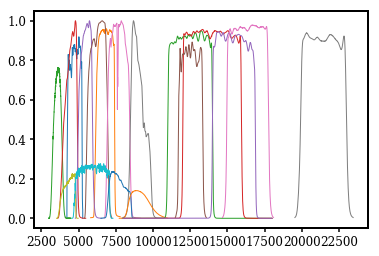

In [249]:
print(redshift_1)
filter_fn_list = []
path = "/Volumes/My Passport/TAPS/filter/goodsn/"
import glob, os
os.chdir(path)
for i in range(1,19):
    for file in glob.glob("f"+str(i)+"_*"):
        print(file)
        fn = path+file
        filter_fn_list.append(fn)
# filter_fn_list[0]
    filter_curve = np.loadtxt(fn)
#     print(filter_curve.size)#[:,0]
    plt.plot(filter_curve[:,0],filter_curve[:,1])

In [322]:
model_wave = model1_wave*(1+redshift_1)
model_flux = model1_flux
def all_same(items):
    return all(x == items[0] for x in items)

1 f1_KPNO_Mosaic.U.dat.txt
1502
2 f2_B_subaru.res.txt
380
4427.6 0.34070023229745416 [7.75554537] [22.76354589] 23
3 f3_V_subaru.res.txt
372
5471.22 0.42322026073746605 [379.99685374] [897.87018486] 68
4 f4_r_subaru.res.txt
378
6534.16 0.69172952861803 [890.80447705] [1287.79304656] 75
5 f5_i_subaru.res.txt
436
7975.890000000001 1.022479281140017 [1425.26336298] [1393.92884459] 100
6 f6_z_subaru.res.txt
396
9069.21 0.9998617303804983 [972.75896116] [972.89348277] 114
7 f7_Keck_LRIS.g.dat.txt
1742
4780.0 0.362662071642213 [101.18464498] [279.00531348] 15
8 f8_Keck_LRIS.Rs.dat.txt
1622
6830.000000000001 0.9008828186370247 [1070.84026324] [1188.6565501] 80
9 f9_HST_ACS_HRC.F435W.dat.txt
2902
4317.0 0.33826978529740315 [0.00245355] [0.00725323] 3
10 f10_HST_ACS_HRC.F606W.dat.txt
5490
5918.0 0.6098142585989241 [332.71523666] [545.60094646] 98
11 f11_HST_ACS_HRC.F775W.dat.txt
4574
7693.0 1.0252170882780833 [302.76393348] [295.31690111] 93
12 f12_HST_ACS_HRC.F850LP.dat.txt
6384
9055.0 0.99238

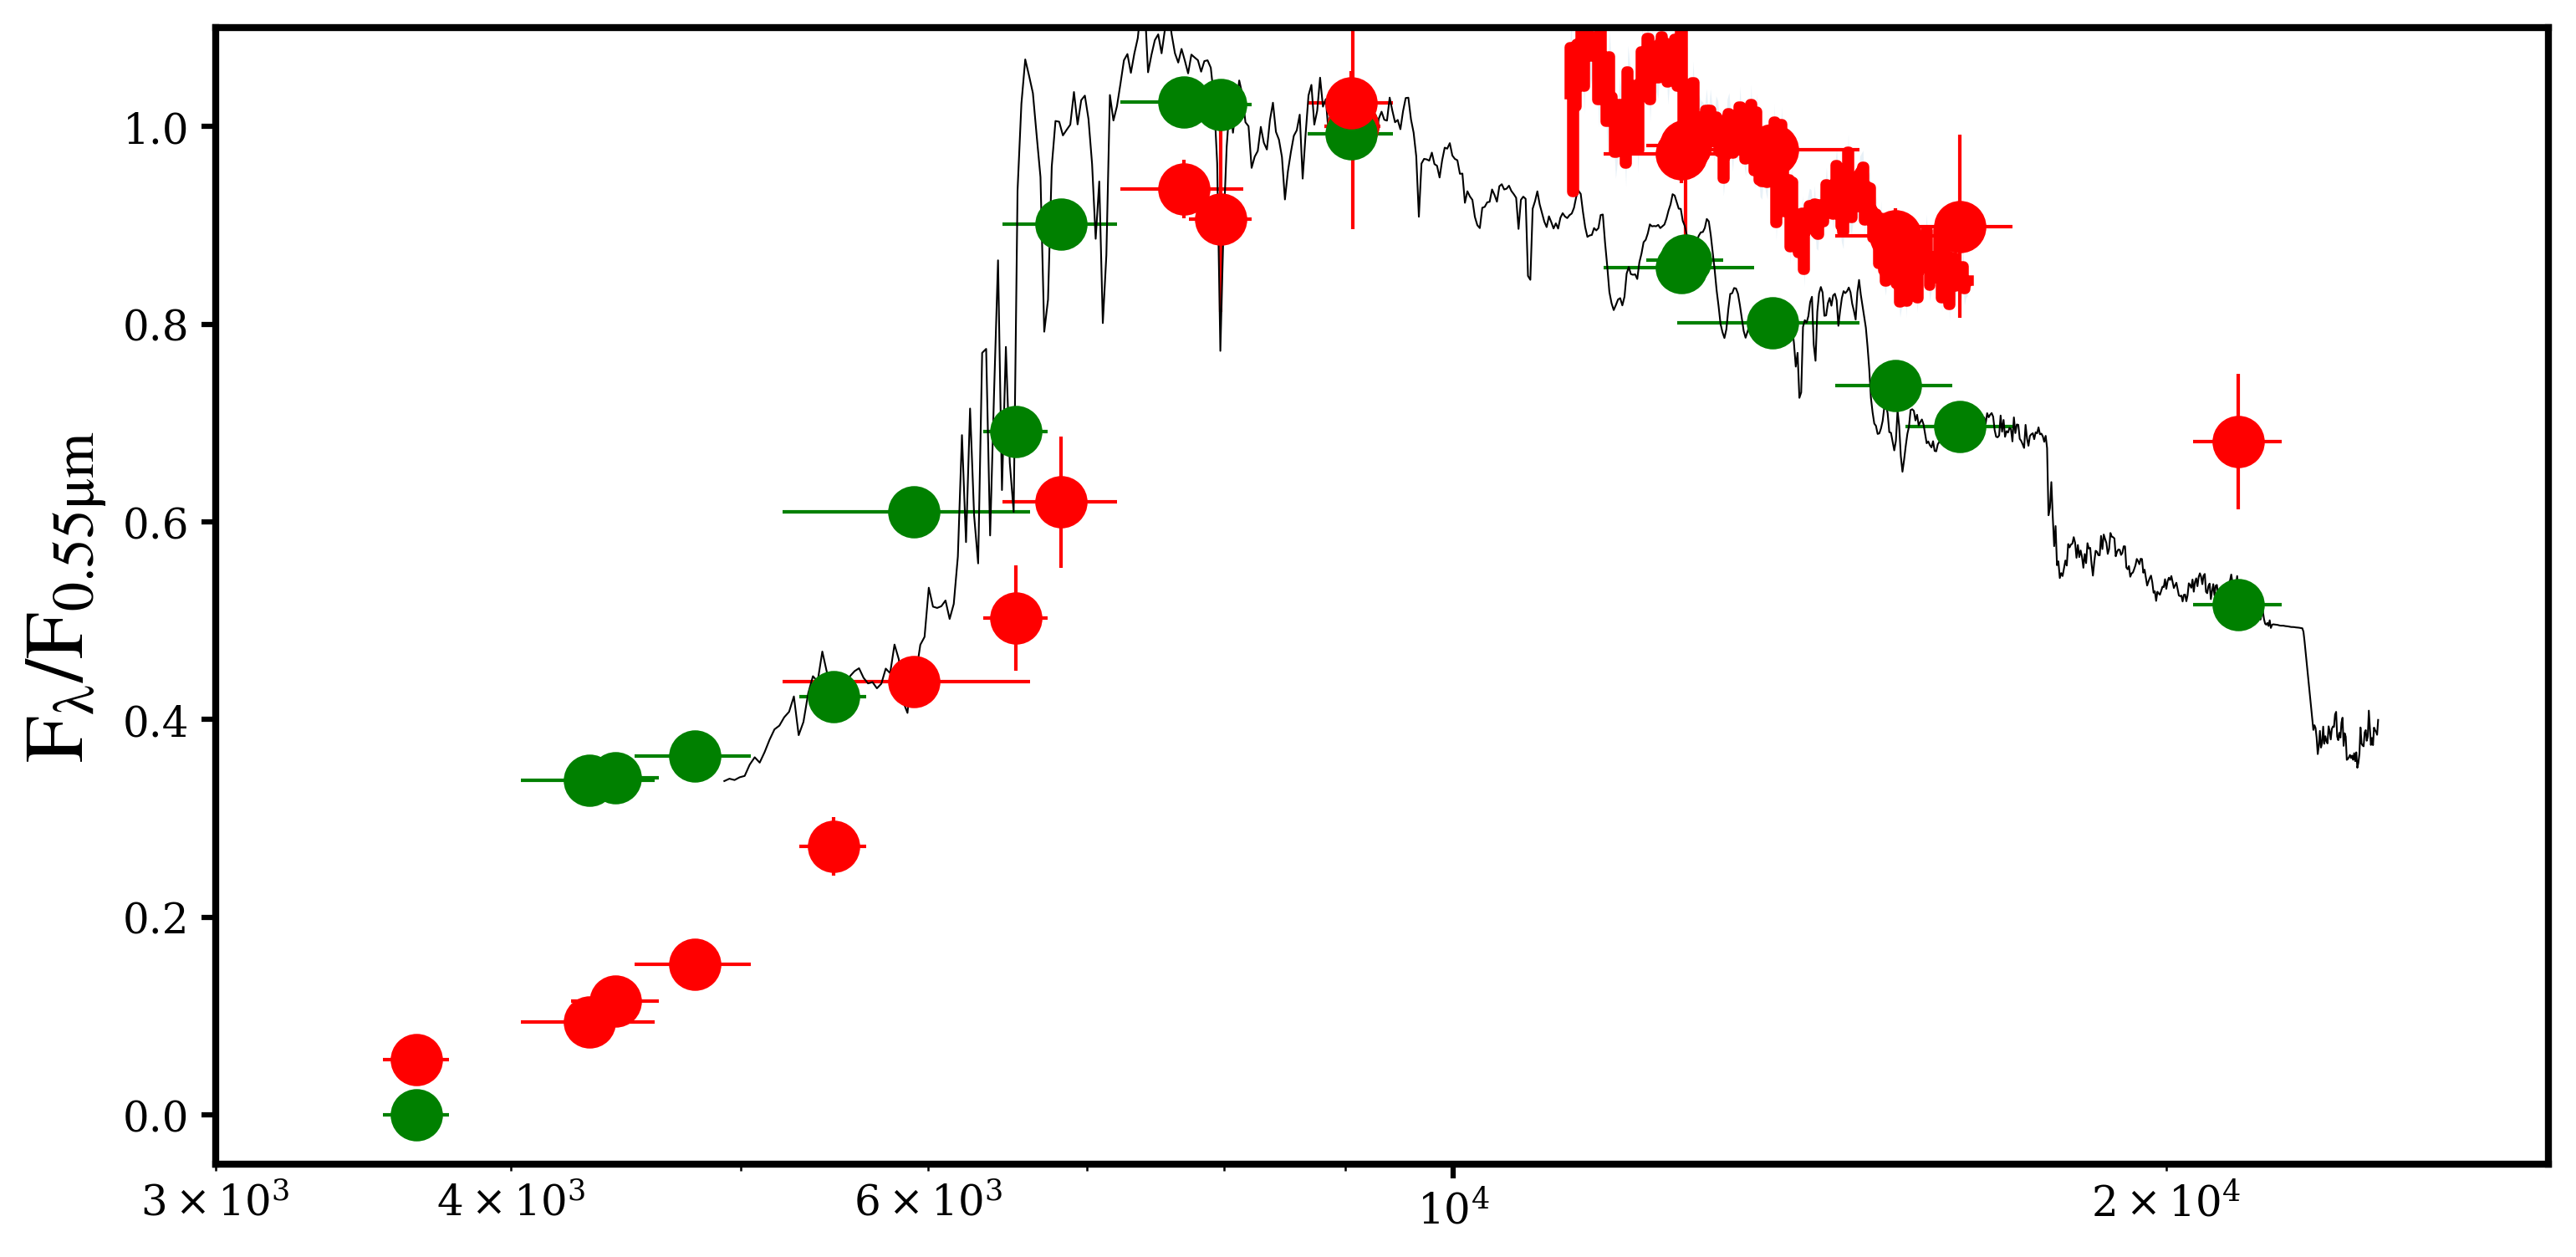

In [323]:
def all_same(items):
    return all(x == items[0] for x in items)

plt.figure(figsize=(12,6),dpi=300)
plt.plot(model_wave, model_flux, color='k',lw=0.5)
photometry_list = np.zeros(len(wave_list))
plt.xlim([3.e3,2.9e4])
plt.ylim([-0.05, 1.1])
plt.semilogx()
plt.step(x*(1+redshift_1), y, color='r',lw=3)
plt.fill_between(x*(1+redshift_1),(y+y_err),(y-y_err),alpha=0.1)
plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)

for i in range(1,19):
    for file in glob.glob("f"+str(i)+"_*"):
        print(i,file)
        fn = path+file
        filter_fn_list.append(fn)
        filter_curve = np.loadtxt(fn)
        print(filter_curve.size)#[:,0]
        
    sum_flambda_AB_K = 0
    sum_transmission = 0
    length = 0

    for j in range(len(filter_curve)-1):
        wave_inter = np.zeros(len(model_wave))
        wave_inter[:-1] = np.diff(model_wave)
        index = np.where(model_wave<filter_curve[j+1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        wave_inter = wave_inter[index]
        index = np.where(wave>filter_curve[j,0])
        wave = wave[index]
        flux = flux[index]
        wave_inter = wave_inter[index]
        n = len(flux)
        if n!= 0 and n!=1:
            try:
                transmission = np.interp(wave, filter_curve[j:j+2,0], filter_curve[j:j+2,1])
            except:
                print('Error')
            # Checking if all spectral elements are the same
            if all_same(wave_inter):
                flambda_AB_K = np.sum(flux*transmission)
                sum_flambda_AB_K += flambda_AB_K
                sum_transmission += np.sum(transmission)
                length = length+1
            else:
                flambda_AB_K = np.sum(flux*transmission*wave_inter)
                sum_flambda_AB_K += flambda_AB_K
                sum_transmission += np.sum(transmission*wave_inter)
                length = length+1
        elif n==1:
            transmission = np.interp(wave, filter_curve[j:j+2,0], filter_curve[j:j+2,1])
            flambda_AB_K = flux[0]*transmission[0]
            sum_flambda_AB_K += flambda_AB_K*wave_inter
            sum_transmission += np.sum(transmission)*wave_inter#/len(transmission)#np.trapz(transmission, x=wave)
            length = length+1
    if length == 0:
        photometry_list[i-1]=0
    else:
        photometry_list[i-1] = sum_flambda_AB_K/sum_transmission
        print(wave_list[i-1]*(1+redshift_1), photometry_list[i-1], sum_flambda_AB_K, sum_transmission,length)#, wave[int(n/2)])
    plt.errorbar(wave_list[i-1]*(1+redshift_1),photometry_list[i-1],\
                 xerr=band_list[i-1], color='g', fmt='o',  markersize=14)
    plt.errorbar(wave_list[i-1]*(1+redshift_1), photometric_flux[i-1],\
                 xerr=band_list[i-1], yerr=photometric_flux_err_mod[i-1], color='r', fmt='o', label='photometric data', markersize='14')
chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2


In [310]:
chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2
print(chisquare_photo_list)
print(np.sum(chisquare_photo_list))

[5.42943194e-01 5.04535488e-01 5.22258631e-02 4.04880229e-01
 2.24452990e-01 7.87484257e-02 3.03289221e-02 6.84973975e-02
 2.09499060e+00 8.19191752e+00 6.68431661e+00 2.25475457e+00
 3.01791316e-03 9.96884770e-01 4.56011763e-01 3.80396584e-04
 4.41078442e-02 2.69335195e-01]
22.90232970372959


In [318]:
chi2_M05 = chisquare_photo(model1_wave, model1_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
chi2_M13 = chisquare_photo(model2_wave, model2_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)
chi2_BC = chisquare_photo(model3_wave, model3_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod)


1 f1_KPNO_Mosaic.U.dat.txt
2 f2_B_subaru.res.txt
3 f3_V_subaru.res.txt
4 f4_r_subaru.res.txt
5 f5_i_subaru.res.txt
6 f6_z_subaru.res.txt
7 f7_Keck_LRIS.g.dat.txt
8 f8_Keck_LRIS.Rs.dat.txt
9 f9_HST_ACS_HRC.F435W.dat.txt
10 f10_HST_ACS_HRC.F606W.dat.txt
11 f11_HST_ACS_HRC.F775W.dat.txt
12 f12_HST_ACS_HRC.F850LP.dat.txt
13 f13_wfc3-F125W.res.txt
14 f14_wfc3-F140W.res.txt
15 f15_wfc3-F160W.res.txt
16 f16_Subaru_MOIRCS.J.dat.txt
17 f17_Subaru_MOIRCS.H.dat.txt
18 f18_Subaru_MOIRCS.Ks.dat.txt
[1.53817574e+01 2.03046992e+02 2.63544583e+01 1.26954317e+01
 1.51813556e+00 1.78603382e-06 1.08230471e+02 1.79394960e+01
 1.25904007e+03 1.34262286e+02 8.88029191e+00 9.63284214e-01
 1.49682410e+01 3.29006031e+01 2.91019434e+01 1.34643742e+00
 4.82820504e+00 5.71860329e+00]
1877.1767089622808
1 f1_KPNO_Mosaic.U.dat.txt
2 f2_B_subaru.res.txt
3 f3_V_subaru.res.txt
4 f4_r_subaru.res.txt
5 f5_i_subaru.res.txt
6 f6_z_subaru.res.txt
7 f7_Keck_LRIS.g.dat.txt
8 f8_Keck_LRIS.Rs.dat.txt
9 f9_HST_ACS_HRC.F435W.dat